# Pricing equity options
In this notebook I price American equity options using volatility tracking, riskless yield curve construction, and options pricing code from this package. I ensure that all market and economic data required for options pricing is obtained from [FRED](https://fred.stlouisfed.org) and [Yahoo-finance](https://finance.yahoo.com) using [pandas-datareader](https://pydata.github.io/pandas-datareader/).

This notebook can also be used as a tutorial to using the `pricing.curves`, `pricing.options`, `volatility.parameter_estimators`, and `volatility.volatility_trackers` packages in this repository.

## Constructing a riskless yield curve for USD
The first thing we need to do to price any option on a US equity is construct the so-called riskless yield curve for USD. This is because pricing of derivatives is done in _the riskneutral world_ where all investors are assumed not to require a premium for additional risks, hence future cashflows are discounted using the riskless rate to obtain the NPV of the cashflow.

I use the Fed Funds effective rate and US Treasury Yields as proxies for riskless rates. Ideally, using OIS swap rates might be better as treasury yields tend to be slightly lower given the preferred tax treatment of treasuries. However US Treasury Rates are available for free from [FRED](https://fred.stlouisfed.org) with daily frequency while OIS swap rates not and the difference is pretty small.

I use the following dataseries from FRED to accomplish the task:
* DFF &mdash; Federal Funds Effective Rate (daily frequency)
* DGS1MO &mdash; Market Yield on U.S. Treasury Securities at 1-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS3MO &mdash; Market Yield on U.S. Treasury Securities at 3-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS6MO &mdash; Market Yield on U.S. Treasury Securities at 6-Month Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS1 &mdash; Market Yield on U.S. Treasury Securities at 1-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS2 &mdash; Market Yield on U.S. Treasury Securities at 2-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS3 &mdash; Market Yield on U.S. Treasury Securities at 3-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS5 &mdash; Market Yield on U.S. Treasury Securities at 5-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS7 &mdash; Market Yield on U.S. Treasury Securities at 7-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS10 &mdash; Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS20 &mdash; Market Yield on U.S. Treasury Securities at 20-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)
* DGS30 &mdash; Market Yield on U.S. Treasury Securities at 30-Year Constant Maturity, Quoted on an Investment Basis (daily frequency)

In the `pricing.curves.YieldCurve` class I use cubic splines by default to interpolate when constructing the curve. See [this article](http://web.math.ku.dk/~rolf/HaganWest.pdf) for more details on interpolation methods if you want to know more. Cubic splines is pretty advanced.

In [9]:
import locale
from datetime import date, datetime

from dateutil.relativedelta import relativedelta
import pandas_datareader.data as web
from pandas.tseries.offsets import BDay
import numpy as np

from volatility import parameter_estimators
from volatility import volatility_trackers
from pricing import curves

_ = locale.setlocale(locale.LC_ALL, '')

In [2]:
today = date.today()
# Constructing the riskless yield curve based on the current fed funds rate and treasury yields
data = web.get_data_fred(
    ['DFF', 'DGS1MO', 'DGS3MO', 'DGS6MO', 'DGS1', 'DGS2', 'DGS3', 'DGS5', 'DGS7', 'DGS10', 'DGS20', 'DGS30'],
    today - BDay(2), today)
data.dropna(inplace=True)

cur_date_curve = data.index[-1].date()

# Convert to percentage points
data /= 100.

# Some adjustments are required to bring FED Funds rate to the same day count convention and compounding frequency
# as treasury yields (actual/actual with semi-annual compounding):
# 1. https://www.federalreserve.gov/releases/h15/default.htm -> day count convention for Fed Funds Rate needs
# to be changed to actual/actual
# 2. Conversion to APY: https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics/interest-rates-frequently-asked-questions
data.DFF *= (366 if curves.YieldCurve.is_leap_year(cur_date_curve.year) else 365) / 360 # to x/actual
data.DFF = 2 * (np.sqrt(data.DFF + 1) - 1)

offsets = [relativedelta(), relativedelta(months=+1), relativedelta(months=+3), relativedelta(months=+6),
           relativedelta(years=+1), relativedelta(years=+2), relativedelta(years=+3), relativedelta(years=+5),
           relativedelta(years=+7), relativedelta(years=+10), relativedelta(years=+20),
           relativedelta(years=+30)]

# Define the riskless yield curve
curve = curves.YieldCurve(today, offsets, data[cur_date_curve:cur_date_curve + BDay()].to_numpy()[0, :],
                          compounding_freq=2)

### Optional: Visualizing the riskless yield curve for USD

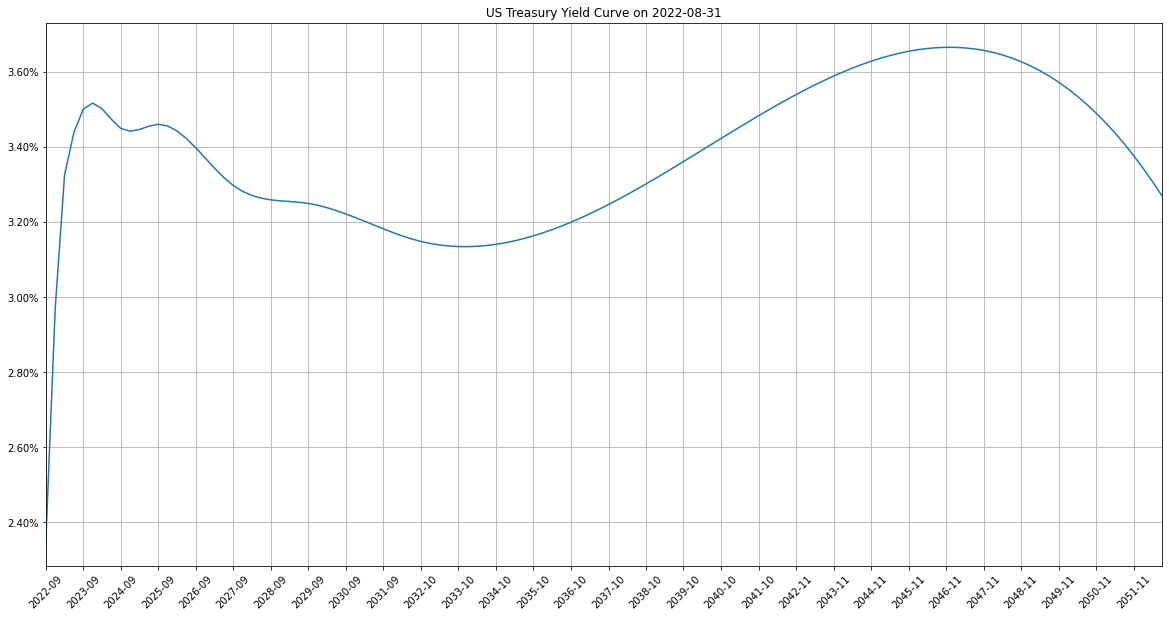

In [5]:
import matplotlib.ticker as mtick
curve_points = curve.get_curve_points(120)
ax = curve_points.plot(figsize=(20,10), grid=True, title='US Treasury Yield Curve on ' + cur_date_curve.strftime('%Y-%m-%d'),
                       xlim=(curve_points.index[0], curve_points.index[-1]),
                       xticks=curve_points.index[::4], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), curve_points.index[::4])))

## Estimating and forecasting volatility of the stock, options on which we want to price
Now that the riskless curve has been constructed, the next thing to do is obtain the accurate volatility estimate for the stock whose options we want to price. There are various different methods for doing it. The most common are  the Exponentially Weighted Moving Average (EWMA) and GARCH(1, 1) methods. You can read about them on the Internet or delve into John C. Hull's [Risk Management and Financial Institutions](http://www-2.rotman.utoronto.ca/~hull/riskman/index.html) or [Options, Futures, and Other Derivatives](http://www-2.rotman.utoronto.ca/~hull/ofod/index.html). For the purposes of pricing options GARCH(1, 1) is preferred because it supports volatility forecasting for future maturities by incorporating mean reversion (and volatility of equeities lends itself to mean reversion). In this notebook I therefore use GARCH(1, 1).

### GARCH(1, 1)
In otder to use GARCH(1, 1) one first needs to estimate it's parameters based on the historical data for the equity whose options you want to price. GARCH(1, 1) has three parameters &mdash; ω, α, and β. I use the maximum likelihood method to estimate them, which is an optimization task. The `volatility.parameter_estimators.GARCHParameterEstimator` class comes to rescure. _Implementation detail_: In that class I use Google's TensorFlow 2.x to optimize for maximum likelihood. Alternatively I could've use [SciPy](https://docs.scipy.org/doc/scipy/tutorial/optimize.html). *NB* When estimating ω, α, and β it's vital to use _adjusted closing_ prices, i.e. prices that have been adjusted for dividends and stock splits. Failing to do that will result in too high an estimate. Yahoo Finance provides such prices in the 'Adj Close' column.

#### Estimating GARCH(1, 1) parameters for Apple

In [7]:
TICKER = 'AAPL'

# I'll use price changes since 1st Jan 2018 to estimate GARCH(1, 1) ω, α, and β
start = date(2018, 1, 1)
data = web.get_data_yahoo(TICKER, start, today)
asset_prices = data['Adj Close']

vol_estimator = parameter_estimators.GARCHParameterEstimator(asset_prices)
print('Optimal values for GARCH(1, 1) parameters:\n\tω=%.12f, α=%.5f, β=%.5f'
      % (vol_estimator.omega, vol_estimator.alpha, vol_estimator.beta))

/usr/local/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


Objective function: 8168.82596 after 129 iterations
Optimal values for GARCH(1, 1) parameters:
	ω=0.000021548480, α=0.12223, β=0.82745


#### Forecasting volatility for Apple
Now that we have the obtined optimal values for GARCH(1, 1) parameters ω, α, and β, we can proceed to forecast its volatility. I crated class `volatility.parameter_estimators.GARCHVolatilityTracker` to assist in it.

In [11]:
vol_tracker = volatility_trackers.GARCHVolatilityTracker(vol_estimator.omega, vol_estimator.alpha,
                                                         vol_estimator.beta, asset_prices)

# Let's get volatility forecase for October 21st options
maturity_date = date(2022, month=10, day=21)
vol = vol_tracker.get_annual_term_volatility_forecast(curve.to_years(maturity_date))
print('Volatility of %s for term %.4f years: %.5f' % (TICKER, curve.to_years(maturity_date), vol))

Volatility of AAPL for term 0.1342 years: 0.26851
